In [1]:
import numpy as np
import scipy.integrate as integrate1
import matplotlib.pyplot as plt
%matplotlib inline

/Users/gabrielfior/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def return_sandia_value(E,material='Rb'):
    #// fSandiaTable [n][0]    - left energy borders in   keV   !!!
    #00054 // fSandiaTable [n][1-4]  - Photoelectric cross-section coefficients
    #00055 //                          in cm^2 keV^(1-4)/g , respectively
    #https://www-zeuthen.desy.de/geant4/geant4.9.3.b01/G4StaticSandiaData_8hh-source.html
    sandia_Rb = np.array((
[0.01,0.4606E+04,0.0000E+00,0.0000E+00, 0.0000E+00],
[0.0305,       0.1441E+04, -0.1761E+03,  0.6821E+01,  0.4470E-01 ] ,
[ 0.111,       -0.6763E+03,  0.6772E+04, -0.1372E+04,  0.7035E+02 ] ,
[ 0.3,         -0.3457E+03,  0.2591E+04,  0.1242E+04, -0.3481E+03] ,
[1.805,        0.3524E+03, -0.3194E+04,  0.1657E+05,  0.1224E+05 ] ,
[ 1.863,       -0.4025E+03,  0.1067E+05,  0.8396E+04, -0.2275E+04 ] ,
[2.065,        0.5234E+01,  0.7494E+03,  0.5033E+05, -0.4276E+05 ] ,
[15.2,        -0.2207E+01,  0.2653E+03,  0.6269E+06, -0.3163E+07 ] ,
[100.0,        0.1101E+01, -0.4280E+03,  0.6664E+06, -0.3481E+07 ] ,
[ 500.0,        0.3467E+00,  0.4515E+03,  0.3525E+06,  0.2783E+08 ] 
    ))    
    sandia_Ar = np.array((
    [ 0.01,        -8.294E+04,   5.720E+03,  -1.101E+02,   6.668E-01  ] ,
 [ 0.04,        -1.401E+03,   9.577E+02,  -7.842E+01,   1.797E+00  ] ,
 [ 0.245,       -0.2244E+03,  0.1388E+04,  0.2571E+04, -0.5113E+03 ] ,
 [ 3.203,       -0.1446E+02,  0.4359E+03,  0.6578E+05, -0.7284E+05 ] ,
 [ 20.0,         0.8786E+00, -0.3001E+03,  0.7682E+05, -0.1219E+06 ] ,
 [ 100.0,        0.6779E-01, -0.2695E+02,  0.5069E+05,  0.5281E+06 ] ,
  [500.0,        0.2598E-01,  0.3454E+02,  0.1059E+05,  0.1068E+08 ] 
))

    if material=='Rb':
        sandia=sandia_Rb
    elif material=='Ar':
        sandia=sandia_Ar

    index1 = sandia.shape[0]
    index_return = index1-1
    try:
        for i in range(index1):
            if E == sandia[i,0]:
                index_return = i
            elif E>sandia[i,0] and E<sandia[i+1,0]:
                index_return = i
            elif E>sandia[-1,0]:
                index_return=index1-1
                break
            elif E<sandia[0,0]:
                index_return=0
                break
            
    except IndexError:
        pass
        
    list1 = list(sandia[index_return])
    list1=list1[1:]
    #print list1
    sum_terms = 0.
    #print E
    for i,j in enumerate(list1):
        
        sum_terms += j/np.power(E,(i+1))  
    
    
    #return sandia[index_return], sum_terms
    return E,sum_terms

In [3]:
def beta_from_energy(E):
    """
    E given in eV
    """
    exp1 = E/(938.)
    beta = np.sqrt(1. - ((1/exp1)**2))
    gamma = 1./np.sqrt(1.-(beta*beta))
    Ekmax = 2*.511*gamma**2
    me_m = 1./1836.
    Ekright = 2.*.511*(beta**2)*(gamma**2)/(1.+2*(me_m)*gamma + (me_m**2))
    return gamma,beta,Ekmax,Ekright

In [4]:
# fc = sigma_gamma/(1.097x1e-16 x 18) 18 = Z_argon

In [36]:
# Calculate 10 eV for argon
def calculate_fig_21(E,particle_energy):
    #E=10. #ev
    #particle_energy = 1e12 #ev
    Emax = beta_from_energy((particle_energy/1e6)+938)[-1] *1e6 # in eV
    Emax = 100.*1e3 #eV
    beta = beta_from_energy((particle_energy/1e6)+938)[1]
    term1 = (1./E) - (1./Emax)
    A = 0.000110592*1e6 #ev/cm 
    #obtain linearly spaced f(E) between 0 and E, then integrate

    nterms = 1000
    list_f_e=[]
    list_energies=[]
    for j in np.linspace(0.01,E/1.e3,nterms,endpoint=True):#eV
        f_e = return_sandia_value(j,'Ar')[1]*(40./(6.*1.097*18.))*1.e-5 #send in keV
        list_f_e.append(f_e)
        list_energies.append(j)

    nterms2=1000
    list_f_e2=[]
    list_energies2=[]
    for jj in np.linspace(E,Emax,nterms2,endpoint=True):
        f_e_term2 = return_sandia_value(jj/1.e3,'Ar')[1]*(40./(6.*1.097*18.))*1e-5
        list_f_e2.append(f_e_term2)
        list_energies2.append(jj)

    #term1
    array_f_e=np.array(list_f_e)
    array_energies=np.array(list_energies)
    #integrate
    #int_from_f = integrate1.romb(array_f_e)
    int_from_f = integrate1.simps(array_f_e,array_energies)
    term1 *= int_from_f
    #term2
    #integrate from E to Emax [(A/beta**2)*f_e/E * log(2*mec^2 *beta**2 /(1-beta**2)E) - beta**2 +1
    #- E/Emax]dE
    mec2 = .511*1e6 #ev
    array_f_e2=np.array(list_f_e2)
    array_energies2=np.array(list_energies2)
    array_f_e3 = (array_f_e2 / array_energies2)*\
    (np.log(2*mec2*beta*beta/((1-beta*beta)*array_energies2))- beta**2 +1 - (array_energies2/Emax))

    #print 'log: '+str(np.log(2*mec2*beta*beta/((1-beta*beta)*array_energies2)))
    term2 = integrate1.simps(array_f_e3,array_energies2)

    final_term = (A/beta**2)*(term2+term1)
    return final_term

In [28]:
# Calculate 10 eV for argon
def calculate_dsigmadE(E,particle_energy):
    #E=10. #ev
    #particle_energy = 1e12 #ev
    #Emax = beta_from_energy((particle_energy/1e6)+938)[-1] *1e6 # in eV
    #Emax = 100.*1e3 #eV
    beta = beta_from_energy((particle_energy/1e6)+938)[1]
    Z=18.
    molar_mass = 40.
    conversion_factor = molar_mass/(6.*1.e23)
    # get values from sandia table then convert to right unit
    term1a = return_sandia_value(E/1.e3,'Ar')[1]*conversion_factor*np.log(2.*511.*1e3*beta/(E)) / (E*Z)
    #print 'term1a : '+str(term1a)

    nterms = 1000
    list_sigma_for_integral=[]
    list_energies=[]
    for j in np.linspace(0.01,E/1.e3,nterms):#eV
        sigmadE = return_sandia_value(j,'Ar')[1]*conversion_factor #send in keV
        list_sigma_for_integral.append(sigmadE)
        list_energies.append(j)
                          

    array_sigma=np.array(list_sigma_for_integral)
    array_energies=np.array(list_energies)
    #integrate
    #int_from_f = integrate1.romb(array_f_e)
    int_from_f = integrate1.simps(array_sigma,array_energies)                          
    #print 'int : '+str(int_from_f)

    term1b = 1./(Z*E*E) * int_from_f
                          
    term1 = (1./430.38/beta**2)*(term1a+term1b)
    
    return term1,array_sigma

In [7]:
a,b= calculate_dsigmadE(11.,1e12)



/Users/gabrielfior/anaconda/lib/python2.7/site-packages/scipy/integrate/quadrature.py:348: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x=x.reshape(tuple(shapex))


In [8]:
#print final_term,term1,term2, A, beta
#print len(array_energies2)

In [37]:
list_graph=[]
list_energies=np.linspace(10.,10.*1e3,500)
for energy1 in list_energies:
    list_graph.append(calculate_fig_21(energy1,400.e9))
    
list_graph2=[]
for energy1 in list_energies:
    list_graph2.append(calculate_fig_21(energy1,1200.e9))


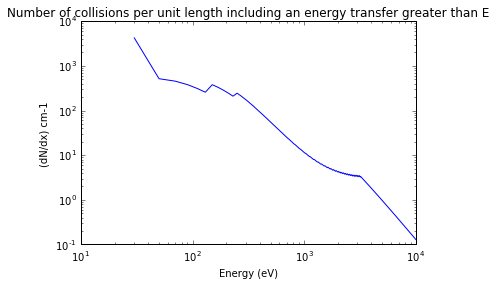

In [76]:
plt.figure(1)
plt.loglog(list_energies,np.array(list_graph))
plt.ylabel('(dN/dx) cm-1')
plt.xlabel('Energy (eV)')
plt.title('Number of collisions per unit length including an energy transfer greater than E')
#plt.loglog(list_energies,np.array(list_graph2))

plt.show()
#https://www-zeuthen.desy.de/geant4/geant4.9.3.b01/G4PAIxSection_8hh-source.html

In [11]:
np.array(list_graph)

array([             nan,   2.74917952e+04,   9.33467198e+03,
         7.45258427e+03,   7.50989008e+03,   7.23158899e+03,
         6.53624894e+03,   5.63460919e+03,   4.69207196e+03,
         3.80096045e+03,   3.00296203e+03,   2.31075107e+03,
         1.72206837e+03,   1.22783511e+03,   8.16530573e+02,
         4.76418902e+02,   3.56989557e+02,   3.04935764e+02,
         3.76205530e+02,   3.56956500e+02,   3.45157213e+02,
         3.37665965e+02,   3.32557211e+02,   3.28661314e+02,
         3.25280040e+02,   3.22009157e+02,   3.18627058e+02,
         3.15024528e+02,   3.11160352e+02,   3.07033276e+02,
         3.02664367e+02,   2.98086020e+02,   2.93335207e+02,
         2.88449433e+02,   2.83464429e+02,   2.78412922e+02,
         2.73324088e+02,   2.68223419e+02,   2.63132830e+02,
         2.58070899e+02,   2.53053174e+02,   2.48092505e+02,
         2.43199363e+02,   2.38382157e+02,   2.33647509e+02,
         2.29000520e+02,   2.24444988e+02,   2.20137800e+02,
         2.15772028e+02,

In [24]:
list_graphdsigma=[]
list_energies=np.linspace(11.,10.*1e3,500)
for energy1 in list_energies:
    list_graphdsigma.append(calculate_dsigmadE(energy1,400.e9)[0])

#plt.loglog(list_energies ,list_graphdsigma)

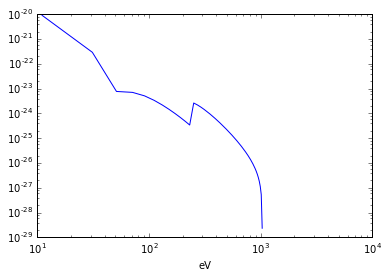

In [25]:
plt.loglog(np.array(list_energies),np.array(list_graphdsigma))
plt.xlabel('eV')

In [41]:
#From drift chambers(1.29): <dE/dx> = int_0^inf E*N*dsigmadE*dE
list_dsigma_129=[]
N129 = 4.32*1e20
list_energies_129=np.linspace(7.,10.*1e3,500)

for energy1 in list_energies_129:
    list_dsigma_129.append(calculate_dsigmadE(energy1,400.e9)[0]*energy1*N129)

#integrate
array129_sigma = np.array(list_dsigma_129)
int129 = integrate1.simps(array129_sigma,list_energies_129)
print int129

9706.42140425


In [42]:
2*np.pi*(2.82*2.82*1e-26)*.511*1e6

2.553283184961243e-19

In [50]:
2.6*1e16*2.5*1e-25*np.log(127*1e9/(4.17))*1e6

0.1569069897693629

In [49]:
1.e-7/85 *6*1e23*37

2.6117647058823524e+16

In [52]:
def calcF(energyy):
    return (1./(4.17*energyy*energyy))

In [58]:
calcF(4.17)

0.01379087541346596

In [63]:
(0.24*6.5*1e-3)**-1

641.025641025641

In [69]:
(4.19*1e-5*37)**-1

645.0364445591174

In [70]:
6.5/1.55

4.193548387096774